Test d'approximant de Padé dans un schéma de Lawson pour la résolution des équations de Lorenz
===

Les équations de Lorenz sont données par :
$$
  \begin{cases}
    \dot{x} &= \sigma (y-x) \\
    \dot{y} &= x(\rho-z)-y \\
    \dot{z} &= xy - \beta z
  \end{cases}
$$

On préfèrera, pour ce que nous souhaitons faire comme manipulations, l'écrire sous une forme matricielle :

$$
  \begin{pmatrix}\dot{x}\\\dot{y}\\\dot{z}\end{pmatrix}
  =
  \begin{pmatrix}
    -\sigma & \sigma & 0 \\
     \rho   & -1     & 0 \\
     0      & 0      & -\beta
  \end{pmatrix}
  \begin{pmatrix}x\\y\\z\end{pmatrix}
  +
  \begin{pmatrix}0 \\ -xz \\ xy \end{pmatrix}
$$

soit, en posant $u=(x,y,z)$ :
$$
  \dot{u} = Lu + N(u)
$$
avec $L$ la matrice de la partie linéaire, et $N:u\mapsto N(u)$ la fonction non-linéaire dépendant de $u$.

> On prendra les paramètres numériques suivant pour assurer le caractère chaotique du problème : $\sigma=10$, $\beta=\,^8/_3$, $\rho=28$ et $u_0=(1,1,1)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
x,y,z = sp.symbols("x y z")
u = sp.Matrix([x,y,z])

s,b,r = sp.symbols(r"\sigma \beta \rho")
L = sp.Matrix([
  [-s , s , 0],
  [ r ,-1 , 0],
  [ 0 , 0 ,-b]
])
def N(u):
  return sp.Matrix([
    0,
    -u[0]*u[2],
    u[0]*u[1]
  ])
num_val = [(s,10),(b,sp.Rational(8,3)),(r,28)]

Pour résoudre numériquement un tel problème, il est possible d'utiliser une méthode de Runge-Kutta, par exemple la méthode RK(3,3) dite de Shu-Osher :

$$
  \begin{aligned}
    u^{(1)} &= u^n + \Delta t (Lu^n+N(u^n)) \\
    u^{(2)} &= \frac{3}{4} u^n + \frac{1}{4}u^{(1)} + \frac{1}{4}\Delta t (Lu^{(1)}+N(u^{(1)})) \\
    u^{n+1} &= \frac{1}{3} u^n + \frac{2}{3}u^{(2)} + \frac{2}{3}\Delta t (Lu^{(2)}+N(u^{(2)}))
  \end{aligned}
$$

Mais il est possible de profiter de la formulation $\dot{u}=Lu+N(u)$ pour utiliser une méthode de Lawson :

$$
  \begin{aligned}
    u^{(1)} &= e^{\Delta t L}u^n + \Delta t e^{\Delta tL}N(u^n)\\
    u^{(2)} &= \frac{3}{4}e^{\frac{\Delta t}{2}L}u^n + \frac{1}{4}e^{-\frac{\Delta t}{2}L}u^{(1)} + \frac{1}{4}\Delta te^{-\frac{\Delta t}{2}L}N(u^{(1)}) \\
    u^{n+1} &= \frac{1}{3}e^{\Delta tL}u^n + \frac{2}{3}e^{\frac{\Delta t}{2}L}u^{(2)} + \frac{2}{3}\Delta te^{\frac{\Delta t}{2}L}N(u^{(2)})
  \end{aligned}
$$

La méthode de Lawson présente un intérêt dans la résolution numérique de certain modèle (voir Vlasov-Maxwell hybride linéarisé : VMHL), mais le calcul efficace de l'exponentielle de la partie linéaire peut présenter un véritable défi. On se propose donc ici de construire une méthode de Lawson où le calcul de l'exponentielle de la matrice est effectuée formellement par un approximant de Padé. Dans le contexte de VMHL cela permet de réintégrer toute la partie linéaire dans $L$ sans se poser la question du calcul par `sympy` de l'exponentielle de la matrice.

Nous cherchons donc ici à résoudre les équations de Lorenz avec trois méthodes différentes :

* La méthode Runge-Kutta classique, qui nous servira de méthode de référence ;
* La méthode de Lawson induite par la même méthode de Runge-Kutta que la résolution de référence ;
* La même méthode de Lawson, mais où l'exponentielle de la partie linéaire n'est pas calculé exactement mais obtenue par un approximant de Padé.

# Résolution par la méthode de Runge-Kutta

In [2]:
dt = sp.symbols("dt")

On va utiliser le schéma RK(3,3) de Shu-Osher pour résoudre :
$$
  \dot{u} = N_{RK}(u)
$$
avec $u=(x,y,z)^\mathsf{T}$ et $N_{RK}$ défini par :
$$
  N_{RK}(u) = \begin{bmatrix}
    \sigma(y-x) \\
    x(\rho-z)-y \\
    xy - \beta z
  \end{bmatrix}
$$

In [3]:
un = sp.Matrix(sp.symbols("x:z_n"))
u1 = sp.Matrix(sp.symbols("x:z_1"))
u2 = sp.Matrix(sp.symbols("x:z_2"))
un1= sp.Matrix(sp.symbols("x:z_{n+1}"))

def N_rk(u):
  x,y,z = u
  return sp.Matrix([
    s*( y-x ) ,
    x*(r-z) - y ,
    x*y - b*z
  ])

stage_u1 = un + dt*N_rk(un)
stage_u2 = sp.Rational(3,4)*un + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*N_rk(u1)
stage_un1 = sp.Rational(1,3)*un + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*N_rk(u2)

Il *suffit* maintenant de prendre ces 3 étages, d'utiliser la fonction `sympy.lambdify` pour convertir ces expressions en fonction `numpy` pour ensuite effectuer des simulations. Mettons en place quelques outils pour faciliter ce processus.

In [4]:
def callable_scheme(stages,nval=num_val):
  """
    convert a tuple of stages into a Runge-Kutta method
  """
  f_stages = [
    sp.lambdify((un,u1,u2,dt),s.subs(nval),modules='numpy')
    for s in stages
  ]
  def rk(u_n,dt):
    u = [ 0.*u_n.copy() for _ in f_stages ]
    for i,fi in enumerate(f_stages):
      u[i] = fi(u_n,*u[:-1],dt)[:,0]
    return u[-1]
  return rk

In [146]:
class simu:
  def __init__(self,label,u0,dt,Tf,func):
    self.label = label
    self.u0 = np.array(u0)
    self.dt = dt
    self.Tf = Tf
    self.func = func
    self.times = list(
        np.linspace(0,Tf,int(Tf/dt),endpoint=False)
      ) + [Tf]
    self.X_sol = np.ndarray((int(Tf/dt)+1,len(u0)))
    self.i = 0
    self.X_sol[self.i] = u0
    self.i += 1
    
  def __call__(self,un):
    un1 = self.func(un,self.dt)
    self.X_sol[self.i] = un1
    self.i += 1
    return un1
  
  @property
  def x(self):
    return self.X_sol[:,0]
  @property
  def y(self):
    return self.X_sol[:,1]
  @property
  def z(self):
    return self.X_sol[:,2]
  
  def display(self):
    import matplotlib.colors as mcolors
    import matplotlib
    palette = [ color[1] for color in mcolors.TABLEAU_COLORS.items() ]

    fig = plt.figure(constrained_layout=True,figsize=(10,15))
    fig.text(0.1,0.85,self.label,fontsize=14)
    gs = fig.add_gridspec(6,1)
    axlist = []

    ax = fig.add_subplot(gs[:3,0],projection='3d')
    ax.plot(self.x,self.y,self.z,label="Lorenz attractor",linewidth=0.375 ,color=palette[4])
    axlist.append(ax)

    #for i,(lab,ax) in enumerate(zip(("x","y","z"),axlist[1:])):
    for i,lab in enumerate(("x","y","z")):
      ax = fig.add_subplot(gs[3+i,0])
      ax.set_ylabel("${}$".format(lab))
      ax.set_xlim((0,100))
      ax.plot( self.times , getattr(self,lab) , label="${}$".format(lab) , color=palette[i] )
      axlist.append(ax)

    handles, labels = map(lambda x:sum(x,start=[]),zip(*map( lambda ax:ax.get_legend_handles_labels() , axlist )))
    fig.legend(handles, labels,loc="center",bbox_to_anchor=(0.5,0.09),ncol=len(labels))
    return fig

Maintenant on va lancer notre run de référence avec la méthode RK(3,3) de Shu-Osher avec comme condition initiale $u_0=(1,1,1)^\mathsf{T}$ et $\Delta t=0.01$.

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


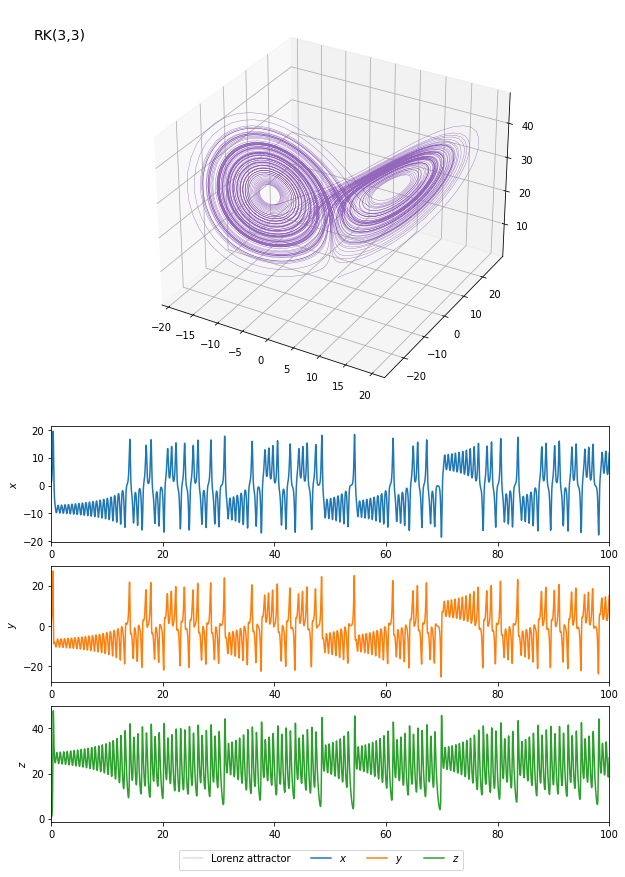

In [6]:
rk33 = callable_scheme((stage_u1,stage_u2,stage_un1))
s_rk33 = simu("RK(3,3)",[1.,1.,1.],0.01,100,rk33)

n_un = s_rk33.u0

for _ in s_rk33.times[1:]:
  n_un = s_rk33(n_un)

s_rk33.display()
plt.show()

# Résolution par la méthode de Lawson

On note :
$$
  L = \begin{pmatrix}
    -\sigma & \sigma & 0 \\
    \rho    & -1     & 0 \\
    0       & 0      & -\beta \\
  \end{pmatrix}
  \qquad
  N:u\mapsto \begin{pmatrix}
    0 \\ -xz \\ xy
  \end{pmatrix}
$$

On souhaite calculer $e^{\Delta t L}$ de manière formelle pour toute valeur de $\Delta t$, cela permettant de construire notre schéma de Lawson.

In [7]:
sp.exp(dt*L)

Matrix([
[2*\rho*\sigma*exp(-dt*(\sigma + 1)/2 + dt*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)/2)/((\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)) - 2*\rho*\sigma*exp(-dt*(\sigma + 1)/2 - dt*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)/2)/((\sigma - sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)), 4*\rho*\sigma**2*exp(-dt*(\sigma + 1)/2 + dt*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)/2)/((\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*(4*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)) + 2*\sigma*(2*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)*exp(-dt*(\sigma + 1)/2 - dt*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)/2)/((\sigma - sqrt(4*\rho*\sigma + \sigm

La librairie `sympy` permet de calcul exacte de l'exponentielle $e^{\Delta t L}$ avec du calcul symbolique, ici pour toute valeur de $\sigma$, $\rho$, $\beta$ et $\Delta t$.

Regardons les valeurs propres de cette matrice, pour différentes valeurs de $\Delta t\in [0,0.1]$, et les valeurs numériques $\sigma=10$, $\beta=\,^8/_3$, $\rho=28$ (précédemment indiquées).

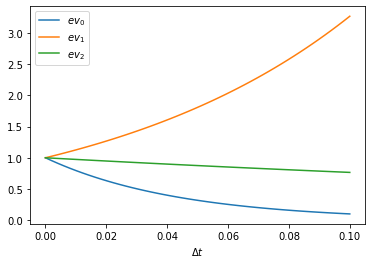

In [8]:
dts = np.linspace(0.0,0.1)
for i,x in enumerate(sp.exp(dt*L).eigenvals()):
  plt.plot(dts,[x.subs(num_val).subs(dt,ndt).evalf() for ndt in dts ],"-",label="$ev_{}$".format(i))
plt.xlabel(r"$\Delta t$")
plt.legend()
plt.show()

Les trois valeurs propres de $e^{\Delta t L}$ sont réelles, et une est plus grande que 1. Cela indique un caractère divergent de la partie linéaire, qui est résolue exactement dans la méthode de Lawson. Or les solutions des équations de Lorenz (avec ces paramètres numériques) ne sont pas divergentes, ce caractère est donc compensé par la partie non-linéaire.

In [9]:
M = sp.MatrixSymbol("M",3,3)
x1,y1,z1 = sp.symbols("x_1 y_1 z_1")
u1 = sp.Matrix([x1,y1,z1])

In [10]:
sp.exp(M)*u1

Matrix([
[x_1*exp(M)],
[y_1*exp(M)],
[z_1*exp(M)]])

> Dans `sympy` l'exponentielle de n'importe quel symbole est un scalaire, il en va de même pour les objets de type `sympy.MatrixSymbol`. Cela pose quelques difficultés pour travailler sur des expressions comportant des exponentielles de matrices. J'ai donc redéfinie l'exponentielle d'une telle matrice (qui n'est qu'un `sympy.MatrixSymbol` sans aucune propriété de l'exponentielle, il est ensuite possible d'effectuer des substitutions pour appliquer n'importe quel fonction pour calculer cette exponentielle).

In [11]:
def ms_exp(expr):
  """
    matrix symbol exponential
  """
  mexp = sp.MatrixSymbol((r"e^{"+sp.latex(expr)+r"}").replace(" ",r"\ "),*(expr).shape)
  mexp.arg = expr
  return mexp

eM = ms_exp(sp.Rational(1,2)*dt*M)
eM*u1

e^{\left(\frac{1}{2}\right)\ dt\ M}*Matrix([
[x_1],
[y_1],
[z_1]])

On apporte quelques fonctions pour aider dans la manipulation de cette exponentielle de matrice.

In [12]:
def ems_args(*arg):
  """
    exponential matrix symbol arguments
  """
  s = str(arg[0])[3:-1].replace(r"\ "," ").replace(r"\left(","").replace(r"\right)","")
  from sympy.parsing.latex import parse_latex
  return parse_latex(s)

def ems_subs(A,B):
  """
    exponential matrix symbol substitution
    substitue matrix A into B in arguments of an ems
    return lambda which only returns arguments substituion
  """
  return lambda *arg : ems_args(*arg).subs(sp.symbols(str(A)),B)

def ems_func(lamb,func):
  """
    exponential matrix symbol function
    get an already define lambda (lamb) substitution
    and apply user define function (func)
  """
  return lambda *arg : func(lamb(*arg))

# for example, replacement in `eM*u1`
# the last replace expression is to evaluate
# (else the matrix product doesn't evaluate)
(eM*u1).replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(M,L),lambda x:2*x/dt)
  ).replace(sp.MatMul,sp.Mul)

ANTLR runtime and generated code versions disagree: 4.9!=4.7.2


Matrix([
[-\sigma*x_1 + \sigma*y_1],
[          \rho*x_1 - y_1],
[              -\beta*z_1]])

La syntaxe est peut-être un peu lourde, mais je n'ai pas trouvé mieux pour le moment. Des tentatives d'héritage de `sympy.MatrixSymbol` ou de `sympy.exp` ont été tenté mais rien n'a été concluant. Passer par la représentation LaTeX, faire quelques manipulations de strings pour ensuite exprimer cela sous forme d'expression `sympy` est la seule solution que j'ai pu trouver...

In [13]:
def N(u):
  def N1(x,y,z):
    return 0
  def N2(x,y,z):
    return -x*z
  def N3(x,y,z):
    return x*y
  return sp.Matrix([ Ni(*u) for Ni in (N1,N2,N3) ])

N(u1)

Matrix([
[       0],
[-x_1*z_1],
[ x_1*y_1]])

On a maintenant tous les outils pour écrire une méthode Lawson-RK(3,3) de Shu-Osher :

$$
  \begin{aligned}
    u_1 &= e^{\Delta t L}u_n + \Delta te^{\Delta t L}N(u_n) \\
    u_2 &= \frac{3}{4}e^{\frac{\Delta t}{2} L}u_n + \frac{1}{4}e^{-\frac{\Delta t}{2} L}u_1 + \frac{1}{4}\Delta te^{-\frac{\Delta t}{2} L}N(u_1) \\
    u_{n+1} &= \frac{1}{3}e^{\Delta t L}u_n + \frac{2}{3}e^{\frac{\Delta t}{2} L}u_2 + \frac{2}{3}\Delta te^{\frac{\Delta t}{2} L}N(u_2)
  \end{aligned}
$$

> Oui j'ai mis des indices en bas pour le temps parce que ça fonctionne mieux avec la génération de code de `sympy`...

In [14]:
smL = sp.MatrixSymbol("L",3,3)

stage_u1 = ms_exp(dt*smL)*un + dt*ms_exp(dt*smL)*N(un)
stage_u2 = sp.Rational(3,4)*ms_exp(dt/2*smL)*un + sp.Rational(1,4)*ms_exp(-dt/2*smL)*u1 + sp.Rational(1,4)*dt*ms_exp(-dt/2*smL)*N(u1)
stage_un1 = sp.Rational(1,3)*ms_exp(dt*smL)*un + sp.Rational(2,3)*ms_exp(dt/2*smL)*u2 + sp.Rational(2,3)*dt*ms_exp(dt/2*smL)*N(u2)

In [15]:
[display(sp.Eq(ui,stage)) for ui,stage in zip((u1,u2,un1),(stage_u1,stage_u2,stage_un1))];

Eq(Matrix([
[x_1],
[y_1],
[z_1]]), dt*e^{dt\ L}*Matrix([
[       0],
[-x_n*z_n],
[ x_n*y_n]]) + e^{dt\ L}*Matrix([
[x_n],
[y_n],
[z_n]]))

Eq(Matrix([
[x_2],
[y_2],
[z_2]]), (dt/4)*e^{-\ \frac{1}{2}\ dt\ L}*Matrix([
[       0],
[-x_1*z_1],
[ x_1*y_1]]) + (1/4)*e^{-\ \frac{1}{2}\ dt\ L}*Matrix([
[x_1],
[y_1],
[z_1]]) + (3/4)*e^{\left(\frac{1}{2}\right)\ dt\ L}*Matrix([
[x_n],
[y_n],
[z_n]]))

Eq(Matrix([
[x_{n+1}],
[y_{n+1}],
[z_{n+1}]]), (2*dt/3)*e^{\left(\frac{1}{2}\right)\ dt\ L}*Matrix([
[       0],
[-x_2*z_2],
[ x_2*y_2]]) + (2/3)*e^{\left(\frac{1}{2}\right)\ dt\ L}*Matrix([
[x_2],
[y_2],
[z_2]]) + (1/3)*e^{dt\ L}*Matrix([
[x_n],
[y_n],
[z_n]]))

Maintenant il ne reste plus qu'à remplacer les objets de type `sympy.MatrixSymbol` (représenté par les $e^{\alpha_i\Delta tL}$) par le calcul par la fonction exponentielle `sympy.exp`.

In [16]:
s1 = stage_u1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:sp.exp(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add).simplify()
s1

ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2


Matrix([
[2*\sigma*(\rho*x_n*((-\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)*exp(dt*(-\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)/2) + (\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*exp(-dt*(\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)/2))*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)*(4*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1) + (-dt*x_n*z_n + y_n)*(2*\rho*\sigma*(-\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)*exp(dt*(-\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)/2) - (\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*(2*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)*exp(-dt*(\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)/2))*(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)

In [17]:
s2 = stage_u2.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:sp.exp(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add).simplify()

ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2


In [18]:
s3 = stage_un1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:sp.exp(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add).simplify()

ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2


/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


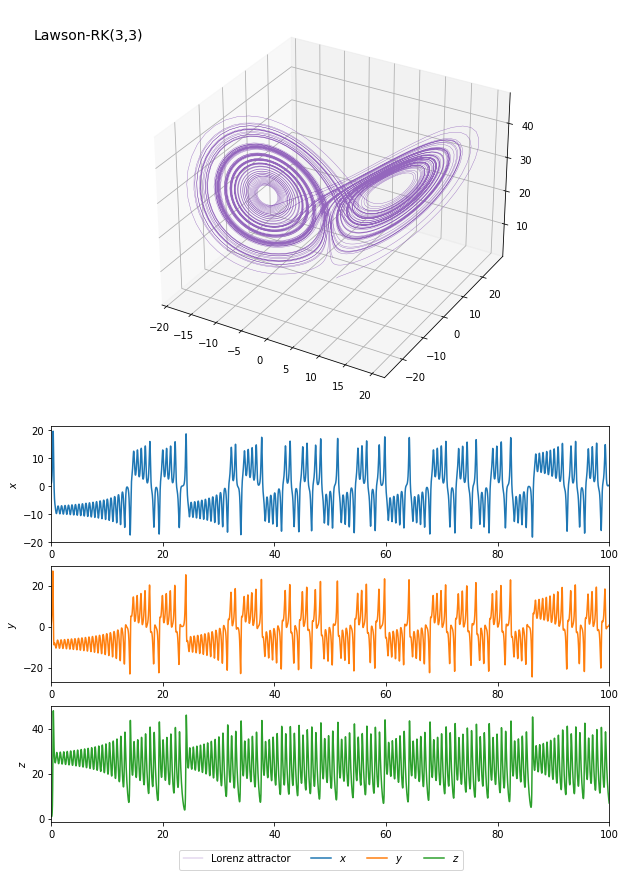

In [19]:
lrk33 = callable_scheme((s1,s2,s3))
s_lrk33 = simu("Lawson-RK(3,3)",[1.,1.,1.],0.01,100,lrk33)

n_un = s_lrk33.u0

for _ in s_lrk33.times[1:]:
  n_un = s_lrk33(n_un)

s_lrk33.display()
plt.show()

On peut comparer la différence entre la méthode RK(3,3) et la méthode de Lawson-RK(3,3).

In [20]:
def multiple_display(*simus):
  import matplotlib.colors as mcolors
  palette = [ color[1] for color in mcolors.TABLEAU_COLORS.items() ]

  fig = plt.figure(constrained_layout=True,figsize=(10,15))
  fig.text(0.1,0.85," vs ".join([simu.label for simu in simus]),fontsize=12)
  gs = fig.add_gridspec(6,1)
  axlist = []

  ax = fig.add_subplot(gs[:3,0],projection='3d')
  for j,simu in enumerate(simus):
    ax.plot(simu.x,simu.y,simu.z,label=simu.label,linewidth=0.375,color=palette[(4+5*j)%len(palette)])
  axlist.append(ax)

  for i,lab in enumerate(("x","y","z")):
    ax = fig.add_subplot(gs[3+i,0])
    ax.set_ylabel("${}$".format(lab))
    ax.set_xlim((0,100))
    
    for j,simu in enumerate(simus):
      ax.plot( simu.times , getattr(simu,lab) , label="${}$ {}".format(lab,simu.label) , color=palette[(i+3*j)%len(palette)] )
      
    axlist.append(ax)

  handles, labels = map(lambda x:sum(x,start=[]),zip(*map( lambda ax:ax.get_legend_handles_labels() , axlist )))
  fig.legend(handles, labels,loc="center",bbox_to_anchor=(0.5,0.09),ncol=int(len(labels)/2))
  plt.show()

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


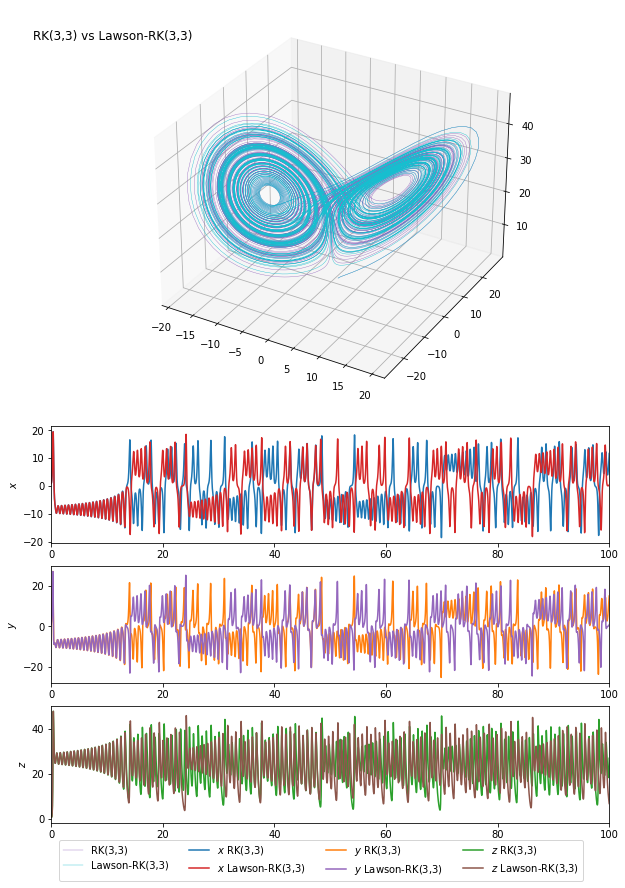

In [21]:
multiple_display(s_rk33,s_lrk33)

On a finalement, des résultats qui divergent relativement rapidement. Cela s'explique par le mécanisme différent des deux méthodes. La partie linéaire (qui a un caractère divergent grossièrement) est résolue exactement dans la méthode de Lawson. Par la suite nous voulons étudier des méthodes de Lawson où la partie linéaire n'est plus résolue exactement mais par un approximant de Padé, la solution de référence devient donc la solution de la méthode Lawson-RK(3,3) car c'est son comportement que l'on souhaite reproduire.

## Résolution par la méthode de Lawson-Padé

In [22]:
def is_matrix(z):
  return ( isinstance(z,sp.Matrix)
        or isinstance(z,sp.ImmutableDenseMatrix)
        or isinstance(z,sp.MatrixSymbol)
        or isinstance(z,sp.MatrixExpr)
         )
def one(z):
  if is_matrix(z):
    return sp.eye(z.cols)
  return 1
def zero(z):
  if is_matrix(z):
    return sp.zeros(z.cols)
  return 0
def inv(z):
  if is_matrix(z):
    return z.inv()
  return 1/z

def pade(n,m):
  def h(p,q):
    fac = sp.factorial
    return lambda x : sum([
      ((fac(p)/fac(p-i)).simplify()/(fac(p+q)/fac(p+q-i)).simplify()*one(x)*x**i/fac(i))
      for i in range(0,p+1)
    ],start=zero(x))

  def k(p,q):
    fac = sp.factorial
    return lambda x : sum([
      (-1)**j*(fac(q)/fac(q-j)).simplify()/(fac(p+q)/fac(p+q-j)).simplify()*one(x)*x**j/fac(j)
      for j in range(0,q+1)
    ],start=zero(x))
  
  return lambda z: h(n,m)(z)*inv(k(n,m)(z))

p33 = pade(3,3)

In [23]:
s1 = stage_u1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p33(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add).simplify()

ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2


In [24]:
s2 = stage_u2.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p33(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add).simplify()

ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2


In [25]:
s3 = stage_un1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p33(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add).simplify()

ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2


/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


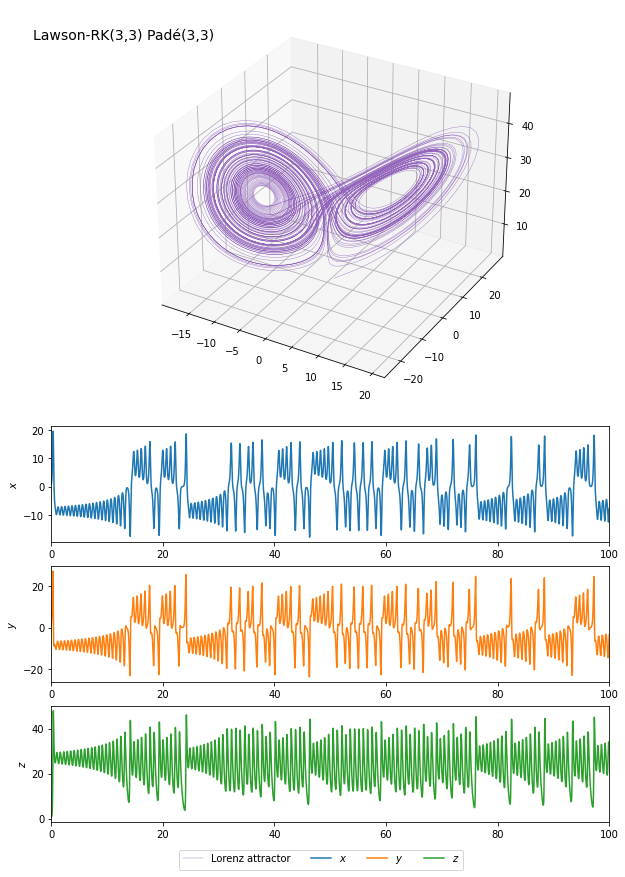

In [26]:
p3lrk33 = callable_scheme((s1,s2,s3))
s_p3lrk33 = simu("Lawson-RK(3,3) Padé(3,3)",[1.,1.,1.],0.01,100,p3lrk33)

n_un = s_p3lrk33.u0

for _ in s_p3lrk33.times[1:]:
  n_un = s_p3lrk33(n_un)

s_p3lrk33.display()
plt.show()

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


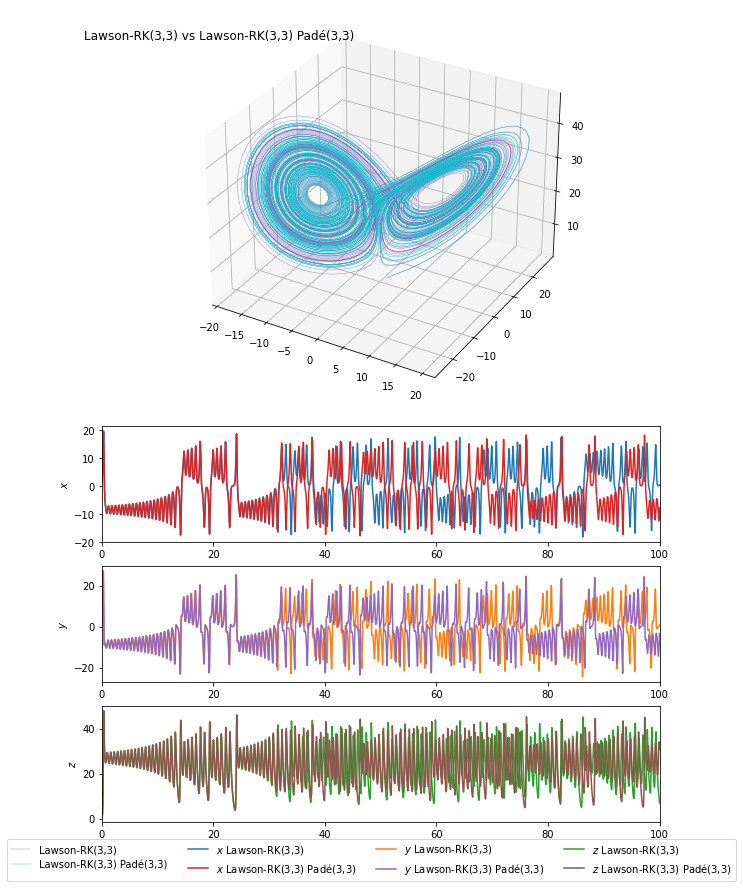

In [27]:
multiple_display(s_lrk33,s_p3lrk33)

L'équation de Lorenz formant, avec ces paramètres numériques, un système chaotique, il est attendu d'obtenir des résultats différents en resolvant le problème avec deux méthodes différentes.

Ici la méthode Runge-Kutta sous-jascente est d'ordre 3, et dans un premier temps on utilise un interpolant de Padé d'*ordre* 3 également. Dans la pratique il semble préférable d'utiliser un approximant d'*ordre* plus élevé que l'intégrateur en temps, mais nous en profitons ici pour voir (numériquement) les limites possibles d'une telle méthode.

> Il est intéressant de regarder un peu plus la notion d'ordre dans les approximants de Padé. Cette notion peu avoir un sens dans le cadre d'un développement de Taylor, peut-être que l'étude théorique commencera par là.

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


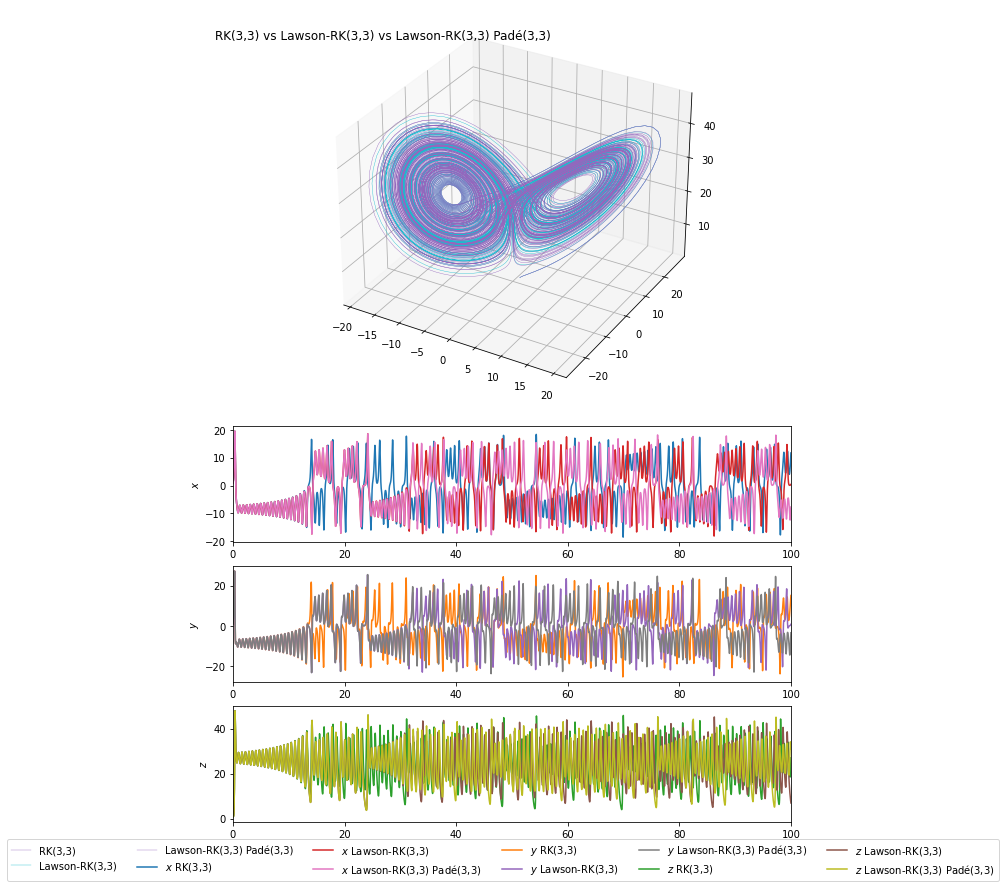

In [31]:
multiple_display(s_rk33,s_lrk33,s_p3lrk33)

In [150]:
def multiple_diff_display(s0,*simus):
  import matplotlib.colors as mcolors
  palette = [ color[1] for color in mcolors.TABLEAU_COLORS.items() ]

  fig = plt.figure(constrained_layout=True,figsize=(10,15))
  fig.text(0.1,0.85,"ref: "+s0.label,fontsize=16)
  fig.text(0.1,0.83," vs ".join([simu.label for simu in simus]),fontsize=12)
  gs = fig.add_gridspec(6,1)
  axlist = []

  ax = fig.add_subplot(gs[:3,0],projection='3d')
  for j,simu in enumerate(simus):
    ax.plot(s0.x-simu.x,s0.y-simu.y,s0.z-simu.z,label=simu.label,linewidth=0.375,color=palette[(4+5*j)%len(palette)])
  axlist.append(ax)

  for i,lab in enumerate(("x","y","z")):
    ax = fig.add_subplot(gs[3+i,0])
    ax.set_ylabel("${}$".format(lab))
    ax.set_xlim((0,100))
    
    for j,simu in enumerate(simus):
      ax.plot( s0.times , getattr(s0,lab)-getattr(simu,lab) , label="${}$ {}".format(lab,simu.label) , color=palette[(i+3*j)%len(palette)] )
      
    axlist.append(ax)

  handles, labels = map(lambda x:sum(x,start=[]),zip(*map( lambda ax:ax.get_legend_handles_labels() , axlist )))
  fig.legend(handles, labels,loc="center",bbox_to_anchor=(0.5,0.09),ncol=min(int(len(labels)/2),4))
  plt.show()

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


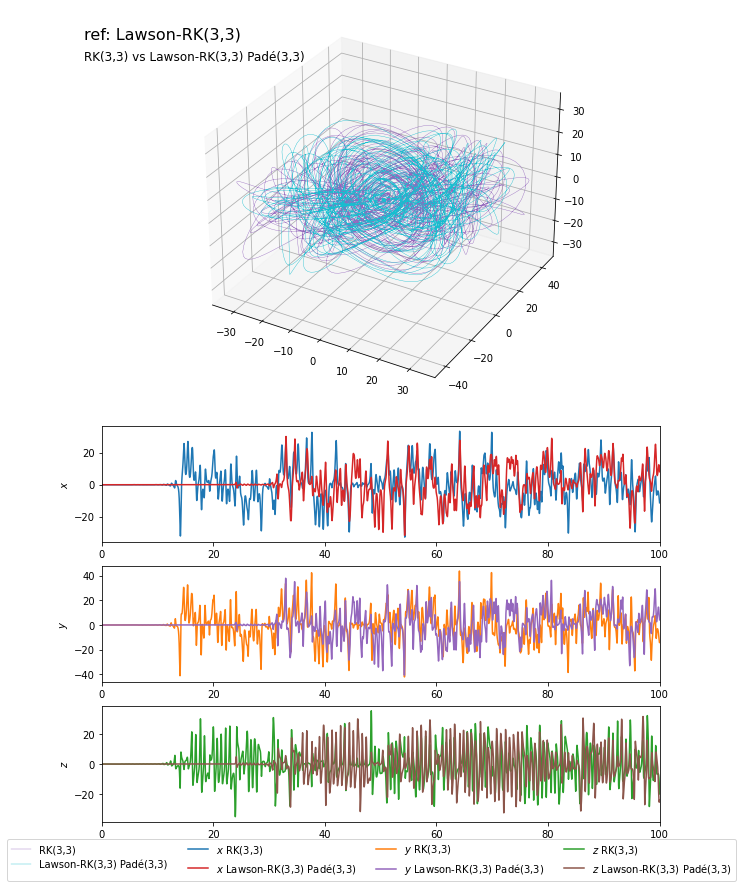

In [57]:
multiple_diff_display(s_lrk33,s_rk33,s_p3lrk33)

In [52]:
p = pade(5,5)

print("> stage 1")
s1 = stage_u1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print("> stage 2")
s2 = stage_u2.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print("> stage 3")
s3 = stage_un1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print()

p5lrk33 = callable_scheme((s1,s2,s3))

> stage 1
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
> stage 2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
> stage 3
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2



/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


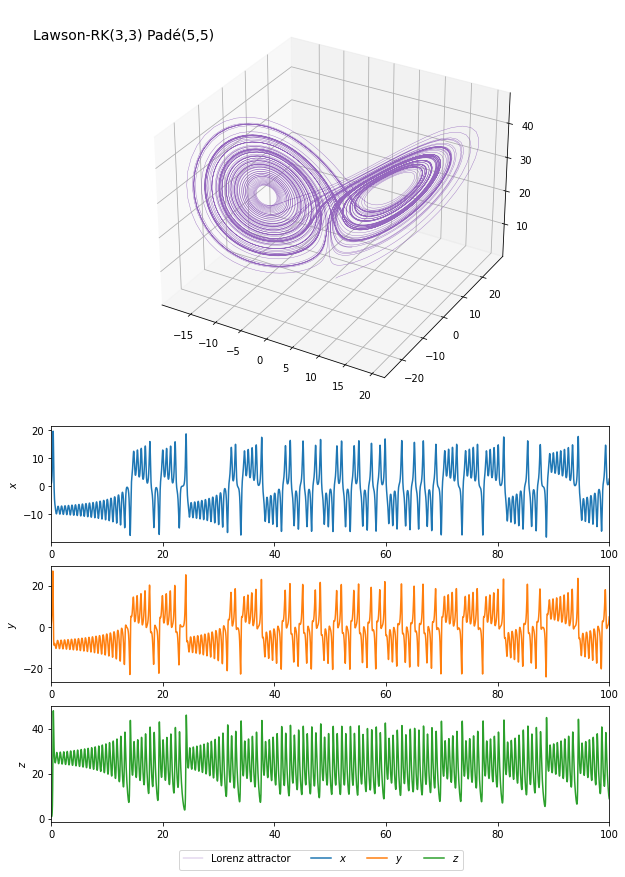

In [62]:
s_p5lrk33 = simu("Lawson-RK(3,3) Padé(5,5)",[1.,1.,1.],0.01,100,p5lrk33)

n_un = s_p5lrk33.u0

for _ in s_p5lrk33.times[1:]:
  n_un = s_p5lrk33(n_un)

s_p5lrk33.display()
plt.show()

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


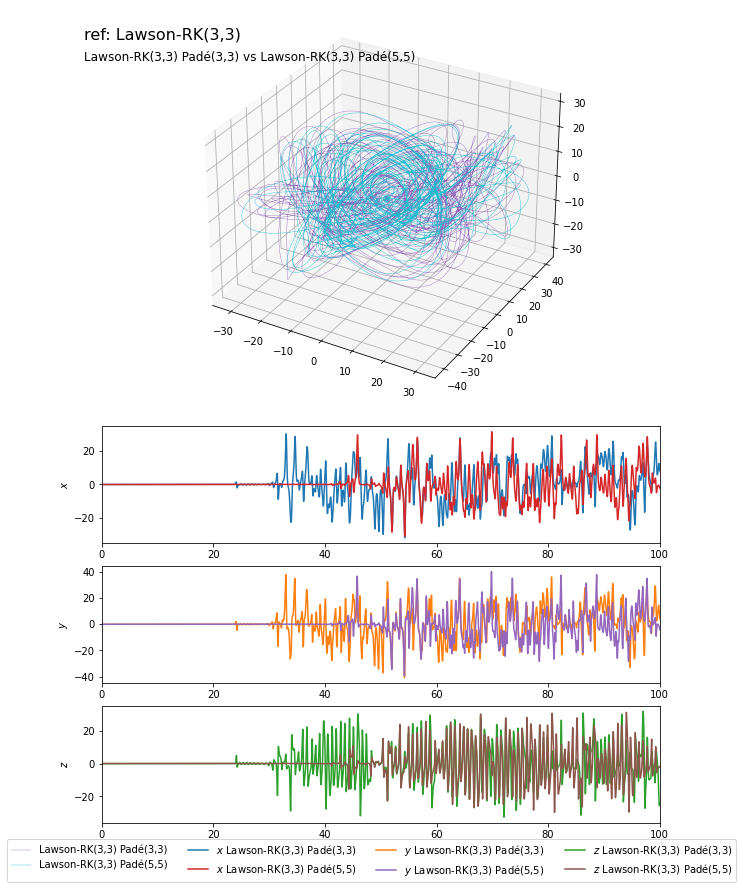

In [63]:
multiple_diff_display(s_lrk33,s_p3lrk33,s_p5lrk33)

In [61]:
p = pade(2,2)

print("> stage 1")
s1 = stage_u1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print("> stage 2")
s2 = stage_u2.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print("> stage 3")
s3 = stage_un1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),lambda x:p(x))
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print()

p2lrk33 = callable_scheme((s1,s2,s3))

> stage 1
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
> stage 2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
> stage 3
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2



/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


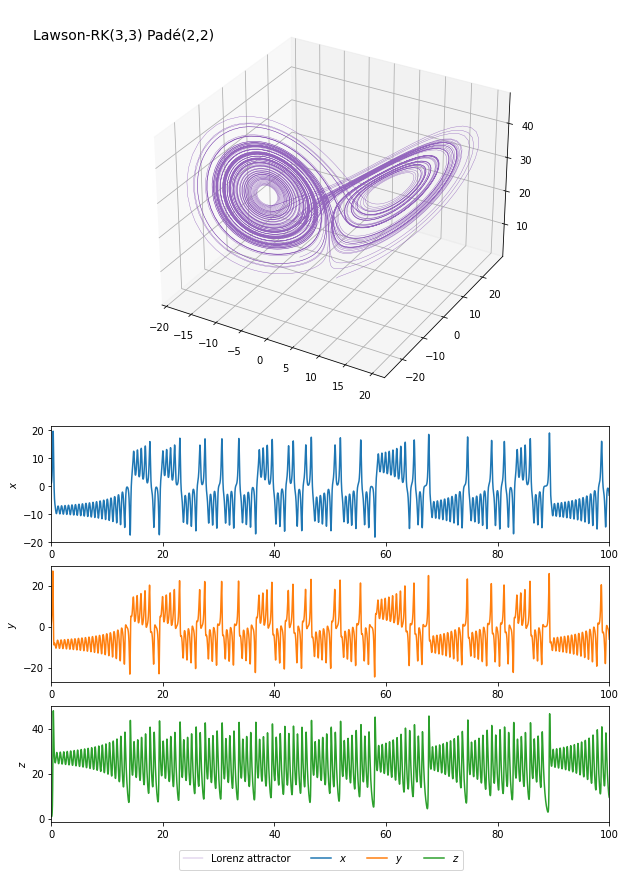

In [64]:
s_p2lrk33 = simu("Lawson-RK(3,3) Padé(2,2)",[1.,1.,1.],0.01,100,p2lrk33)

n_un = s_p2lrk33.u0

for _ in s_p2lrk33.times[1:]:
  n_un = s_p2lrk33(n_un)

s_p2lrk33.display()
plt.show()

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


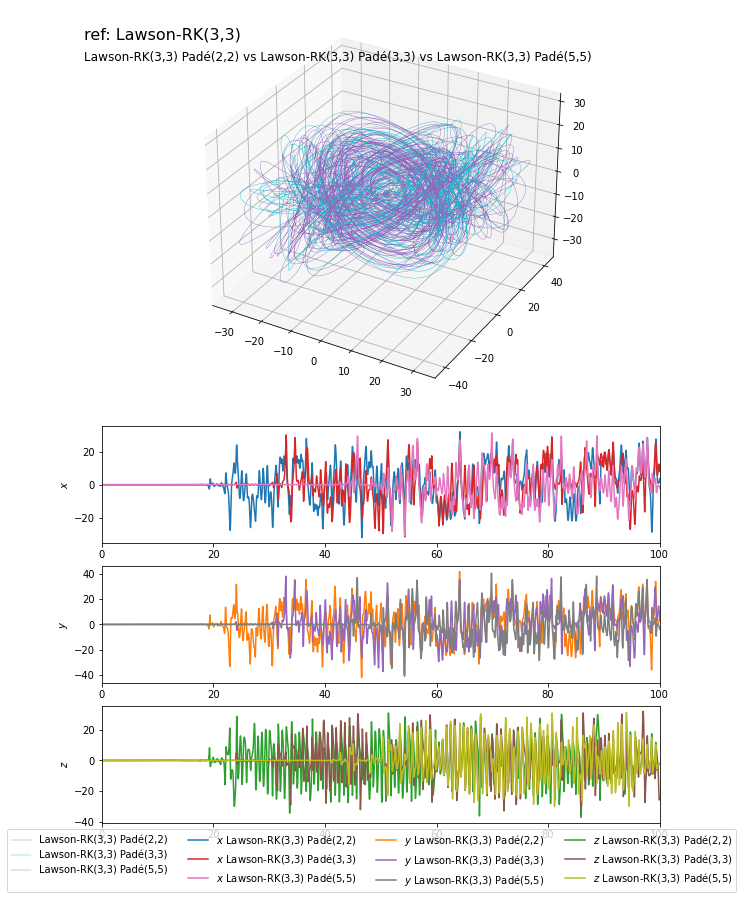

In [152]:
multiple_diff_display(s_lrk33,s_p2lrk33,s_p3lrk33,s_p5lrk33)

<ipython-input-145-ef4467262ac3>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( s_lrk33.times , np.log10(np.sqrt(
<ipython-input-145-ef4467262ac3>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( s_lrk33.times , np.log10(np.sqrt(
<ipython-input-145-ef4467262ac3>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( s_lrk33.times , np.log10(np.sqrt(


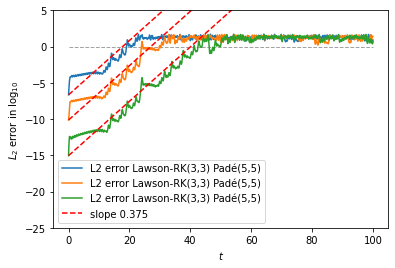

In [145]:
for _simu in (s_p2lrk33,s_p3lrk33,s_p5lrk33):
  plt.plot( s_lrk33.times , np.log10(np.sqrt(
              np.square(s_lrk33.x-_simu.x)+np.square(s_lrk33.y-_simu.y)+np.square(s_lrk33.z-_simu.z)
            )) , label = "L2 error "+simu.label )
  f0 = np.square(s_lrk33.x[1]-_simu.x[1])+np.square(s_lrk33.y[1]-_simu.y[1])+np.square(s_lrk33.z[1]-_simu.z[1])
  plt.plot( s_lrk33.times , 0.375*np.array(s_lrk33.times)+np.log10(np.sqrt(f0)) , 'r--' )
plt.xlabel("$t$")
plt.ylabel(r"$L_2$ error in $\log_{10}$")
plt.hlines(0.,0.,100,linestyles='dashed',color='#a2a2a2',linewidth=1)

plt.plot( s_lrk33.times , 0.375*np.array(s_lrk33.times)+5  , 'r--'  , label="slope 0.375" )
plt.ylim((-25,5))

plt.legend()
plt.show()

In [120]:
import timeit

times_pade = [ timeit.timeit(lambda:pade(n,n)(t*L),number=1) for n in range(2,6) ]

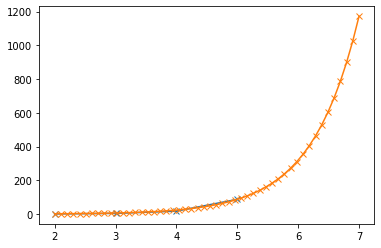

In [140]:
ns = np.linspace(2.0,7.0)
plt.plot(range(2,6),times_pade,"x-")
plt.plot(ns,times_pade[0]*2**(1.875*ns)/np.exp(2.0),"x-")

In [141]:
t = sp.symbols("t",real=True,positive=True)
p = pade(7,7)
pt = p(t*L)

def test(x):
  dt = x[0,0]/-s
  print(dt)
  return pt.subs(t,dt)

In [142]:
print("> stage 1")
s1 = stage_u1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),test)
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print("> stage 2")
s2 = stage_u2.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),test)
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print("> stage 3")
s3 = stage_un1.replace(
    sp.MatrixSymbol,
    ems_func(ems_subs(smL,L),test)
  ).replace(sp.MatMul,sp.Mul).replace(sp.MatAdd,sp.Add)
print()

p7lrk33 = callable_scheme((s1,s2,s3))

> stage 1
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
dt
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
dt
> stage 2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
-dt/2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
dt/2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
-dt/2
> stage 3
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
dt
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
dt/2
ANTLR runtime and generated code versions disagree: 4.9!=4.7.2
dt/2



/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


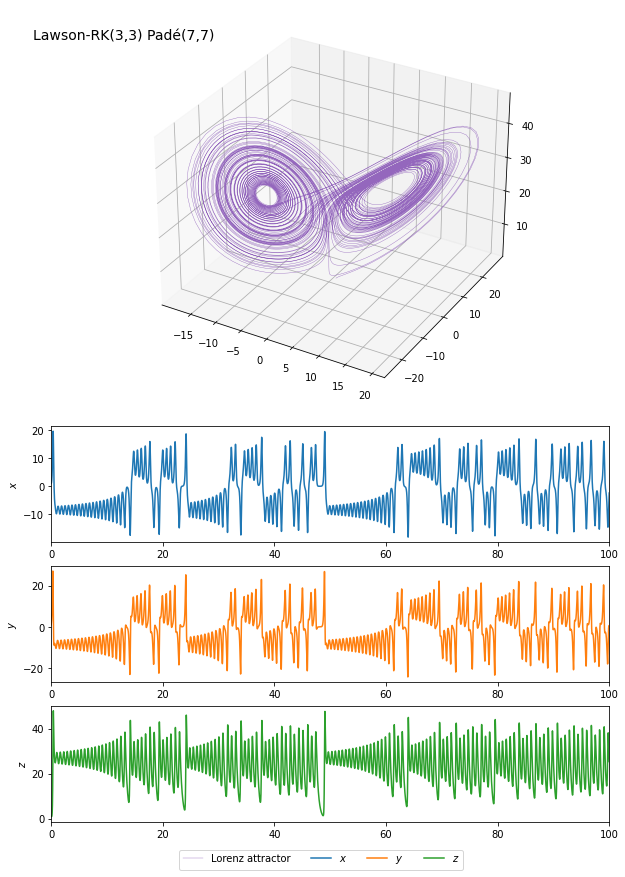

In [147]:
s_p7lrk33 = simu("Lawson-RK(3,3) Padé(7,7)",[1.,1.,1.],0.01,100,p7lrk33)

n_un = s_p7lrk33.u0

for _ in s_p7lrk33.times[1:]:
  n_un = s_p7lrk33(n_un)

s_p7lrk33.display()
plt.show()

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


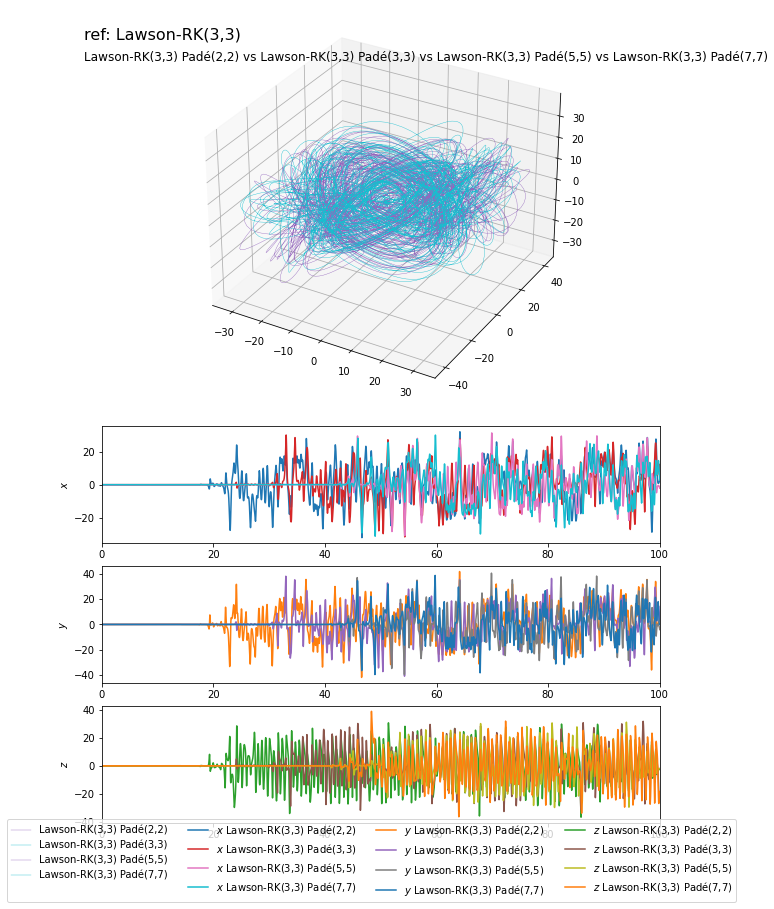

In [151]:
multiple_diff_display(s_lrk33,s_p2lrk33,s_p3lrk33,s_p5lrk33,s_p7lrk33)

<ipython-input-149-b8c4df4a538a>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( s_lrk33.times , np.log10(np.sqrt(
<ipython-input-149-b8c4df4a538a>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( s_lrk33.times , np.log10(np.sqrt(
<ipython-input-149-b8c4df4a538a>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( s_lrk33.times , np.log10(np.sqrt(
<ipython-input-149-b8c4df4a538a>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( s_lrk33.times , np.log10(np.sqrt(


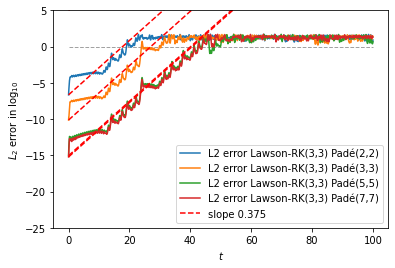

In [149]:
for simu in (s_p2lrk33,s_p3lrk33,s_p5lrk33,s_p7lrk33):
  plt.plot( s_lrk33.times , np.log10(np.sqrt(
              np.square(s_lrk33.x-simu.x)+np.square(s_lrk33.y-simu.y)+np.square(s_lrk33.z-simu.z)
            )) , label = "L2 error "+simu.label )
  f0 = np.square(s_lrk33.x[1]-simu.x[1])+np.square(s_lrk33.y[1]-simu.y[1])+np.square(s_lrk33.z[1]-simu.z[1])
  plt.plot( s_lrk33.times , 0.375*np.array(s_lrk33.times)+np.log10(np.sqrt(f0)) , 'r--' )
plt.xlabel("$t$")
plt.ylabel(r"$L_2$ error in $\log_{10}$")
plt.hlines(0.,0.,100,linestyles='dashed',color='#a2a2a2',linewidth=1)

plt.plot( s_lrk33.times , 0.375*np.array(s_lrk33.times)+5  , 'r--'  , label="slope 0.375" )
plt.ylim((-25,5))

plt.legend()
plt.show()